In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import set_to_nan_based_on_likelihood, plot_ebc,filter_and_interpolate

def ebc_bins(dlc_df, bin_size_angle=6,bin_size_distance=80): 
    top_left_corner = (dlc_df.iloc[0]['top_left_corner x'], dlc_df.iloc[0]['top_left_corner y'])
    top_right_corner = (dlc_df.iloc[0]['top_right_corner x'],dlc_df.iloc[0]['top_right_corner y'])
    bottom_left_corner = (dlc_df.iloc[0]['bottom_left_corner x'], dlc_df.iloc[0]['bottom_left_corner y'])
    bottom_right_corner = (dlc_df.iloc[0]['bottom_right_corner x'], dlc_df.iloc[0]['bottom_right_corner y'])
    angle_bins = np.arange(0,360,bin_size_angle)

    diagonal_distance_arena = math.hypot(top_right_corner[0] - bottom_left_corner[0], top_right_corner[1] - bottom_left_corner[1])
    distance_bins = np.arange(0,diagonal_distance_arena,bin_size_distance)
    return distance_bins,angle_bins

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def lineLineIntersection(A, B, C, D):
    # Line AB represented as a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1*(A[0]) + b1*(A[1])
 
    # Line CD represented as a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2*(C[0]) + b2*(C[1])
 
    determinant = a1*b2 - a2*b1
 
    if (determinant == 0):
        # The lines are parallel. This is simplified
        # by returning a pair of FLT_MAX
        return 'parallel'
    else:
        x = (b2*c1 - b1*c2)/determinant
        y = (a1*c2 - a2*c1)/determinant
        return (x, y)


def calaculate_ebc_head(dlc_df,left_drive_x,left_drive_y,right_drive_x,right_dirve_y,ebc_angle_bin_size,ebc_dist_bin_size):
    top_left_corner = (dlc_df.iloc[0]['top_left_corner x'], dlc_df.iloc[0]['top_left_corner y'])
    top_right_corner = (dlc_df.iloc[0]['top_right_corner x'],dlc_df.iloc[0]['top_right_corner y'])
    bottom_left_corner = (dlc_df.iloc[0]['bottom_left_corner x'], dlc_df.iloc[0]['bottom_left_corner y'])
    bottom_right_corner = (dlc_df.iloc[0]['bottom_right_corner x'], dlc_df.iloc[0]['bottom_right_corner y'])
    distance_bins,angle_bins = ebc_bins(dlc_df,ebc_angle_bin_size,ebc_dist_bin_size)
    ebc_data_final = []
    for i in range(len(left_drive_x)):
        print(i, len(left_drive_x), "egocentric head") #TO VIEW PROGRESS
        ebc_bins_total = np.zeros((len(distance_bins),len(angle_bins)))
        for angle in range(0,360,3):
            center_neck_pos = (left_drive_x[i],left_drive_y[i])
            center_haunch_pos = (right_drive_x[i],right_dirve_y[i]) 
            center_neck_pos = rotate(center_haunch_pos,center_neck_pos,angle=math.radians(-1*angle))
            body_angle_radian_frame = math.atan2(center_haunch_pos[1]-center_neck_pos[1],center_haunch_pos[0]-center_neck_pos[0])

            body_angle_deg_frame = math.degrees(body_angle_radian_frame)

            if body_angle_deg_frame<0:
                body_angle_deg_frame = 360+body_angle_deg_frame
            

            if(body_angle_deg_frame==0):
                #left wall
                interpoint = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_left_corner,top_left_corner)
                min_distance = math.hypot(interpoint[0]-center_neck_pos[0],interpoint[1]-center_neck_pos[1])
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index]+=1

            elif(body_angle_deg_frame>0 and body_angle_deg_frame<90):
                #left wall and top wall
                interpoint_l = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_left_corner,top_left_corner)
                interpoint_t = lineLineIntersection(center_haunch_pos,center_neck_pos,top_left_corner,top_right_corner)
                distance_from_point_l = math.hypot(interpoint_l[0]-center_neck_pos[0],interpoint_l[1]-center_neck_pos[1])
                distance_from_point_t = math.hypot(interpoint_t[0]-center_neck_pos[0],interpoint_t[1]-center_neck_pos[1])
                min_distance = min(distance_from_point_l,distance_from_point_t)
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1
            
            elif(body_angle_deg_frame==90):
                #top wall
                interpoint = lineLineIntersection(center_haunch_pos,center_neck_pos,top_left_corner,top_right_corner)
                min_distance = math.hypot(interpoint[0]-center_neck_pos[0],interpoint[1]-center_neck_pos[1])
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1

            elif(body_angle_deg_frame>90 and body_angle_deg_frame<180):
                #top wall and right wall
                interpoint_l = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_right_corner,top_right_corner)
                interpoint_t = lineLineIntersection(center_haunch_pos,center_neck_pos,top_left_corner,top_right_corner)
                distance_from_point_l = math.hypot(interpoint_l[0]-center_neck_pos[0],interpoint_l[1]-center_neck_pos[1])
                distance_from_point_t = math.hypot(interpoint_t[0]-center_neck_pos[0],interpoint_t[1]-center_neck_pos[1])
                min_distance = min(distance_from_point_l,distance_from_point_t)
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1
                
            elif(body_angle_deg_frame==180):
                #right wall
                interpoint = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_right_corner,top_right_corner)
                min_distance = math.hypot(interpoint[0]-center_neck_pos[0],interpoint[1]-center_neck_pos[1])
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins) 
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1

            elif(body_angle_deg_frame>180 and body_angle_deg_frame<270):
                #right wall and bottom wall
                
                interpoint_l = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_right_corner,top_right_corner)
                interpoint_t = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_left_corner,bottom_right_corner)
                distance_from_point_l = math.hypot(interpoint_l[0]-center_neck_pos[0],interpoint_l[1]-center_neck_pos[1])
                distance_from_point_t = math.hypot(interpoint_t[0]-center_neck_pos[0],interpoint_t[1]-center_neck_pos[1])
                min_distance = min(distance_from_point_l,distance_from_point_t)
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1
            
            elif(body_angle_deg_frame == 270):
                #bottom wall
                interpoint = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_right_corner,bottom_left_corner)
                min_distance = math.hypot(interpoint[0]-center_neck_pos[0],interpoint[1]-center_neck_pos[1])
                distance_bin_index = np.digitize(min_distance,distance_bins)
                angle_bin_index = np.digitize(angle,angle_bins)
                ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1
            
            else:
                #bottom wall and left wall
                interpoint_l = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_left_corner,top_left_corner)
                interpoint_t = lineLineIntersection(center_haunch_pos,center_neck_pos,bottom_left_corner,bottom_right_corner)
                distance_from_point_l = math.hypot(interpoint_l[0]-center_neck_pos[0],interpoint_l[1]-center_neck_pos[1])
                distance_from_point_t = math.hypot(interpoint_t[0]-center_neck_pos[0],interpoint_t[1]-center_neck_pos[1])
                min_distance = min(distance_from_point_l,distance_from_point_t)
                distance_bin_index = np.digitize(min_distance,distance_bins)
                if min_distance<=800:
                    angle_bin_index = np.digitize(angle,angle_bins)
                    #print(i,min_distance,distance_bin_index,angle_bin_index)
                    ebc_bins_total[distance_bin_index-1][angle_bin_index-1]+=1
        
        ebc_data_final.append(ebc_bins_total)
    return np.array(ebc_data_final)

In [ ]:
file = r'\\rhea\E\20240608\WT0008LN\FM\20240608_WT0008LN_M_FM_DMS1_angie_ephys_topDLCephys.h5'
dlc_df = pd.read_hdf(file, 'dlc_df')
phy_df = pd.read_hdf(file, 'phy_df')

In [3]:
file = r'\\rhea\E\20240608\WT0008LN\FM\20240608_WT0008LN_M_FM_DMS1_angie_ephys_topDLCephys.h5'
dlc_df = pd.read_hdf(file, 'dlc_df')
phy_df = pd.read_hdf(file, 'phy_df')

fps = 59.99
likelihood_threshold = 0.95
model_dt = 1/fps # Frame duration in seconds
bin_width = 20 #bin width angles
speed_threshold=0.25
ebc_angle_bin_size = 3
ebc_dist_bin_size = 40

columns_of_interest = ['left_drive','right_drive', 'time']

# Adding timestamps to dlc file and only considering columns of interest
dlc_df['time'] = np.arange(len(dlc_df))/fps

#filter and interpolate
model_data_df,model_t = filter_and_interpolate(dlc_df,columns_of_interest,likelihood_threshold,model_dt,fps)

model_data_df = model_data_df[model_data_df['speed']>speed_threshold]

#model_data_df = model_data_df.dropna()

center_neck_x = list(model_data_df['left_drive x'])
center_neck_y = list(model_data_df['left_drive y'])
center_haunch_x = list(model_data_df['right_drive x'])
center_haunch_y = list(model_data_df['right_drive y'])


ebc_data = calaculate_ebc_head(dlc_df, center_neck_x,center_neck_y,center_haunch_x,center_haunch_y,ebc_angle_bin_size,ebc_dist_bin_size)
distance_bins,angle_bins = ebc_bins(dlc_df,ebc_angle_bin_size,ebc_dist_bin_size)

ebc_data_avg = np.sum(ebc_data,axis=0)
rbins = distance_bins.copy()
abins = np.linspace(0,2*np.pi, 121)

model_data_df['egocentric'] = list(ebc_data)

0 214759 egocentric head
1 214759 egocentric head
2 214759 egocentric head
3 214759 egocentric head
4 214759 egocentric head
5 214759 egocentric head
6 214759 egocentric head
7 214759 egocentric head
8 214759 egocentric head
9 214759 egocentric head
10 214759 egocentric head
11 214759 egocentric head
12 214759 egocentric head
13 214759 egocentric head
14 214759 egocentric head
15 214759 egocentric head
16 214759 egocentric head
17 214759 egocentric head
18 214759 egocentric head
19 214759 egocentric head
20 214759 egocentric head
21 214759 egocentric head
22 214759 egocentric head
23 214759 egocentric head
24 214759 egocentric head
25 214759 egocentric head
26 214759 egocentric head
27 214759 egocentric head
28 214759 egocentric head
29 214759 egocentric head
30 214759 egocentric head
31 214759 egocentric head
32 214759 egocentric head
33 214759 egocentric head
34 214759 egocentric head
35 214759 egocentric head
36 214759 egocentric head
37 214759 egocentric head
38 214759 egocentric h

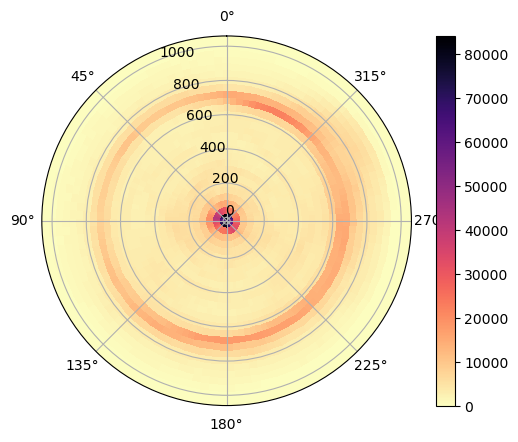

In [4]:
rbins = distance_bins.copy()
abins = np.linspace(0,2*np.pi, (360//ebc_angle_bin_size))

A, R = np.meshgrid(abins, rbins)
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
pc = ax.pcolormesh(A, R, ebc_data_avg, cmap="magma_r")
ax.set_theta_direction(1)
ax.set_theta_offset(np.pi / 2.0)
fig.colorbar(pc)  
plt.show() 

In [15]:
spike_times

array([  48.33276667,   50.63696667,   50.79086667,   52.00876667,
         52.21513333,   52.22466667,   52.33676667,   58.01136667,
        109.79593333,  125.78643333,  147.96736667,  148.44643333,
        148.56756667,  148.6077    ,  148.64563333,  148.68423333,
        148.93856667,  149.11066667,  149.40913333,  164.14246667,
        169.24446667,  184.72253333,  184.79923333,  185.24326667,
        205.56933333,  207.09716667,  207.76203333,  220.58213333,
        220.5878    ,  220.6049    ,  226.3192    ,  237.87893333,
        237.94793333,  237.9847    ,  239.59983333,  239.69263333,
        247.69696667,  253.3343    ,  275.6037    ,  276.1579    ,
        278.4115    ,  278.54036667,  278.73583333,  294.52173333,
        327.6577    ,  338.52983333,  339.58      ,  344.13916667,
        351.60923333,  360.4349    ,  360.94193333,  377.06236667,
        378.26713333,  378.29743333,  378.31753333,  378.61873333,
        385.186     ,  396.9423    ,  397.1584    ,  399.4794 

In [5]:
def calculate_mr(firing_rates, n, m):
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    MR = (1 / (n * m)) * np.sum(firing_rates * np.exp(1j * theta[:, None]), axis=(0, 1))
    return MR

def shuffle_spike_train(spike_times, recording_duration, min_shift=30):
    # Determine maximum shift based on recording duration
    max_shift = recording_duration - min_shift
    
    # Generate a random shift interval
    shift = np.random.uniform(min_shift, max_shift)
    
    # Shift the spike times
    shuffled_times = (spike_times + shift) % recording_duration
    
    return shuffled_times

In [7]:
recording_duration = len(model_data_df)/fps

In [18]:
shuffle_spike_train(spike_times, recording_duration)

array([281.61694768, 281.64738101, 281.65198101, ..., 330.83989546,
       330.90949546, 331.48089546])

In [23]:
mrl_thresholds

NameError: name 'mrl_thresholds' is not defined

In [10]:
cell_numbers = phy_df.index
ebc_plot_data = []
MRLS = []
MALS = []
n = 120  # number of orientation bins
m = 27   # number of distance bins
n_bootstrap = 100  # number of bootstrap iterations
mrl_thresholds = []
for i in cell_numbers:
    spike_times = phy_df.loc[i]['spikeT']

    #removing spike times after camera stopped
    spike_times = spike_times[spike_times<=max(model_t)]

    shuffled_mrls = []

    #binning spikes
    sp_count_ind = np.digitize(spike_times,bins = model_t)

    #-1 because np.digitze is 1-indexed
    sp_count_ind = [i-1 for i in sp_count_ind]

    sp_count_ind = [i for i in sp_count_ind if i in model_data_df.index]

    cell_spikes_egocentric = model_data_df['egocentric'].loc[sp_count_ind]  

    cell_spikes_avg = np.sum(cell_spikes_egocentric,axis = 0)
    cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
    
    cell_spikes_avg[np.isnan(cell_spikes_avg)] = 0
    
    ebc_plot_data.append(cell_spikes_avg)

    firing_rates = cell_spikes_avg.copy().T
    theta = abins.copy()
    MR = (1 / (n * m)) * np.sum(firing_rates * np.exp(1j * theta[:, None]), axis=(0, 1))
    MRL = np.abs(MR)
    MRA = np.angle(MR)

    MRLS.append(MRL)
    MALS.append(MRA)
    

    for _ in range(n_bootstrap):

        shuffled_spikes = shuffle_spike_train(spike_times, recording_duration)

        #binning spikes
        sp_count_ind = np.digitize(shuffled_spikes,bins = model_t)

        #-1 because np.digitze is 1-indexed
        sp_count_ind = [i-1 for i in sp_count_ind]

        sp_count_ind = [i for i in sp_count_ind if i in model_data_df.index]

        cell_spikes_egocentric = model_data_df['egocentric'].loc[sp_count_ind]  

        cell_spikes_avg = np.sum(cell_spikes_egocentric,axis = 0)
        cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
        
        cell_spikes_avg[np.isnan(cell_spikes_avg)] = 0
        

        shuffled_firing_rates = cell_spikes_avg.copy().T
        theta = abins.copy()
        MR = (1 / (n * m)) * np.sum(shuffled_firing_rates * np.exp(1j * theta[:, None]), axis=(0, 1))
        MRL = np.abs(MR)

        # Append to the shuffled MRLs list
        shuffled_mrls.append(MRL)
    mrl_threshold = np.percentile(shuffled_mrls, 99)
    mrl_thresholds.append(mrl_threshold)

C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:28: RuntimeWarning: invalid value encountered in divide
  cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:59: RuntimeWarning: invalid value encountered in divide
  cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:59: RuntimeWarning: invalid value encountered in divide
  cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:59: RuntimeWarning: invalid value encountered in divide
  cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:59: RuntimeWarning: invalid value encountered in divide
  cell_spikes_avg = np.divide(cell_spikes_avg,ebc_data_avg)
C:\Users\plab\AppData\Local\Temp\ipykernel_2072\370600074.py:59: RuntimeWarning: invalid value encountered in divid

In [25]:
len(mrl_thresholds)

31

In [9]:

mrl_thresholds

[0.018266009576460896,
 0.0012617874148837215,
 0.0025663478146657,
 0.0043096590124120215,
 0.0021881389443563176,
 0.0030374719233138133,
 0.002384552013433209,
 0.00113576943582113,
 0.007677087318249099,
 0.0025114712777777417,
 0.012009400116999396,
 0.0017021644880495632,
 0.004582911014610832,
 0.004133044107823308,
 0.032307713675769664,
 0.0016668791015255814,
 0.0022781397071786665,
 0.0023516094473808556,
 0.0010449219192623135,
 0.0142908949609391,
 0.001630760536881541,
 0.005057646790592637,
 0.010393286122645949,
 0.0018256976398466492,
 0.0030330751991086025,
 0.0003242815740377954,
 0.001641273617209447,
 0.001470859542677602,
 0.0030571006888615634,
 0.0015989849720924323,
 0.0003403512586670988]

In [12]:
good_cells = []
for i in range(len(MRLS)):
    if MRLS[i]>mrl_thresholds[i]:
        good_cells.append(MRLS[i])

In [13]:
len(good_cells)

30

In [14]:
len(cell_numbers)

31

In [5]:
fps

59.99

In [9]:
len(model_data_df)/fps

3579.9133188864807

In [ ]:
import numpy as np
from scipy.stats import weibull_min

# Assuming you have the following:
# firing_rates: original array of shape (120, 27) containing firing rates
# spike_times: original spike times array
# behavior_times: behavioral data times array

def calculate_mr(firing_rates, n, m):
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    MR = (1 / (n * m)) * np.sum(firing_rates * np.exp(1j * theta[:, None]), axis=(0, 1))
    return MR

def shuffle_spike_train_no_behavior(spike_times, recording_duration, min_shift=30):
    # Determine maximum shift based on recording duration
    max_shift = recording_duration - min_shift
    
    # Generate a random shift interval
    shift = np.random.uniform(min_shift, max_shift)
    
    # Shift the spike times
    shuffled_times = (spike_times + shift) % recording_duration
    
    return shuffled_times

# Parameters
n = 120  # number of orientation bins
m = 27   # number of distance bins
n_bootstrap = 100  # number of bootstrap iterations

# Placeholder for shuffled MRL values
shuffled_mrls = []

for _ in range(n_bootstrap):
    # Shuffle the spike train
    shuffled_spikes = shuffle_spike_train(spike_times, behavior_times)
    
    # Calculate firing rates for the shuffled spikes (you would need to bin your spikes based on behavior times)
    # Assuming the function `calculate_firing_rates(shuffled_spikes)` gives you a (120, 27) array for shuffled spikes
    shuffled_firing_rates = calculate_firing_rates(shuffled_spikes)
    
    # Calculate MR and MRL for the shuffled data
    MR_shuffled = calculate_mr(shuffled_firing_rates, n, m)
    MRL_shuffled = np.abs(MR_shuffled)
    
    # Append to the shuffled MRLs list
    shuffled_mrls.append(MRL_shuffled)

# Calculate the 99th percentile of the shuffled MRLs
mrl_threshold = np.percentile(shuffled_mrls, 99)
